# Advanced dynamic bidirectional Seq2Seq with Attention 

## TensorFlow Tutorial

In this tutorial we will create neural machine translation based on modern Seq2Seq with Attention Mechanism algorithm from scratch.  There are several tutorial:

* Official TensorFlow Tutorial https://github.com/tensorflow/nmt
* Official PyTorch Tutorial  https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html


But official TensorFlow Tutorial does not cover the realization of attention mechanism (using only attention wrapper), and from my opinion it is the main part of modern neural translation. The main idea was to provide a deep tutorial that step by step covers all aspect of seq2seq with attention algorithm. We we’ll use TensorFlow framework just, because we want to provide good implemented and working example based on (https://github.com/ematvey/tensorflow-seq2seq-tutorials without attention mechanism) of this idea on low level, as good as it was done in original PyTorch tutorial.

![title](pictures/attention_mechanism.jpg)

Let start from importing libs for machine learning, linear algebra and image plotting. And start tf session.

In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.reset_default_graph()
sess = tf.InteractiveSession()

In [4]:
tf.__version__

'1.13.0-rc1'

Now we create two functions for random string generation with variable length and fix vocab size.
This is done for sentence imitation for task as machine translation.

batch_size=200 - e.g. 200, how many sentence fit in model at one learning step (depends on ram or vram).

length_from=3, length_to=15 - e.g. usually sentence have length from 3 to 15.

vocab_lower=2 - we start our words index from 2. Why? "0" for zero PAD for long sentence. "1" for EOS end of the sentence token. 

vocab_upper=10 - e.g. our simulation of the language will have only 8 words.

## Batch Generation

In [5]:
def batch_gen(inputs, max_sequence_length=None):
    sequence_lengths = [len(seq) for seq in inputs]
    batch_size = len(inputs)

    if max_sequence_length is None:
        max_sequence_length = max(sequence_lengths)

    inputs_batch_major = np.zeros(shape=[batch_size, max_sequence_length], dtype=np.int32)

    for i, seq in enumerate(inputs):
        for j, element in enumerate(seq):
            inputs_batch_major[i, j] = element

    inputs_time_major = inputs_batch_major.swapaxes(0, 1)

    return inputs_time_major, sequence_lengths


def random_sequences(length_from, length_to,
                     vocab_lower, vocab_upper,
                     batch_size):
    if length_from > length_to:
            raise ValueError('length_from > length_to')

    def random_length():
        if length_from == length_to:
            return length_from
        return np.random.randint(length_from, length_to + 1)

    while True:
        yield [
            np.random.randint(low=vocab_lower,
                              high=vocab_upper,
                              size=random_length()).tolist()
            for _ in range(batch_size)
        ]

In [10]:
batch_size = 200

PAD = 0 # zero padding for long sentences
EOS = 1 # end of the sentence token

batches = random_sequences(length_from=3, length_to=15,
                           vocab_lower=2, vocab_upper=10,
                           batch_size=batch_size
                           )

Let print two random seq sentences.

In [11]:
tmp_seq = next(batches)[:2]
print(tmp_seq)

[[6, 8, 3, 7, 9, 8, 8], [3, 2, 3, 8, 2, 5, 4, 9, 3, 4, 7]]


In our example we will translate random sentence seq in the same order if sentence starts from odd word index: "1", "3", "5", "7", "9" and in reverse order if starts from even word index: "2", "4", "6", "8". It is done to better attention illustration.

In [12]:
tmp_decoder_targets, _ = batch_gen(
            [(list(np.flip(sequence,0))) + [EOS] + [PAD] * 2 if sequence[0]%2 == 0 
             else (sequence) + [EOS] + [PAD] * 2  for sequence in tmp_seq]
            )
print(tmp_decoder_targets.T)

[[8 8 9 7 3 8 6 1 0 0 0 0 0 0]
 [3 2 3 8 2 5 4 9 3 4 7 1 0 0]]


As we can see, the see the first seq is reversed, becouse it starts from "8" even word index.

## Model

Let initialize our metaparameters.

In [22]:
vocab_size = 10 # in real language can be more than ~ 100,000
input_embedding_size = 20 # e.g. 10 -> 20,  like word2vec 100,000 -> 300

encoder_hidden_units = 10 # number of hidden neurons in encoder LSTM
decoder_hidden_units = encoder_hidden_units * 2 # we will decode bidirectional (factor x2) encoding

attention_size = 8 # number of hidden neurons in attention for basic decoder and encoder out representation
attention_out_size = 16 # number of output neurons from attention, sizes of real examples ~ 300

Initialize input and output placeholders.

In [23]:
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs') # input seq
encoder_inputs_length = tf.placeholder(shape=(None,), dtype=tf.int32, name='encoder_inputs_length') # seq len
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets') # output seq

## Embeddings

In [24]:
embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1, 1), 
                         dtype=tf.float32, name='embeddings'
                         )
encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)

## Encoder

In [25]:
from tensorflow.python.ops.rnn_cell import LSTMCell, LSTMStateTuple

encoder_input_keep_prob = tf.placeholder(tf.float32, name='encoder_input_keep_prob')
encoder_output_keep_prob = tf.placeholder(tf.float32, name='encoder_output_keep_prob')
encoder_state_keep_prob = tf.placeholder(tf.float32, name='encoder_state_keep_prob')

encoder_cell_lstm = LSTMCell(encoder_hidden_units)

encoder_cell = tf.nn.rnn_cell.DropoutWrapper(
    encoder_cell_lstm,
    input_keep_prob=encoder_input_keep_prob,
    output_keep_prob=encoder_output_keep_prob,
    state_keep_prob=encoder_state_keep_prob,
    seed=42
    )

((encoder_fw_outputs,
  encoder_bw_outputs),
 (encoder_fw_final_state,
  encoder_bw_final_state)) = (
    tf.nn.bidirectional_dynamic_rnn(cell_fw=encoder_cell,
                                    cell_bw=encoder_cell,
                                    inputs=encoder_inputs_embedded,
                                    sequence_length=encoder_inputs_length,
                                    dtype=tf.float32, time_major=True)
    )

# concatenation for use information from forward and backward lstm encoding
encoder_outputs = tf.concat((encoder_fw_outputs, encoder_bw_outputs), 2)

# letters h and c are used to denote "output value" and "cell state"
encoder_final_state_c = tf.concat(
    (encoder_fw_final_state.c, encoder_bw_final_state.c), 1)

encoder_final_state_h = tf.concat(
    (encoder_fw_final_state.h, encoder_bw_final_state.h), 1)

encoder_final_state = LSTMStateTuple(
    c=encoder_final_state_c,
    h=encoder_final_state_h
    )

## Attention Decoder

The idea of decoder. We use raw rnn to control the internal loop for decoding to insert the attention and predicted output as a next input.
We will describe general idea of attention:
* (1) Attention weights is a softmax (from 0 to 1) coefficient of impotence of encoder output on each step
* (2) Context vector is a weights sum of all encoder outputs and their attention coefficient
* (3) Attention vector is a embedded (neural tanh activated layer) of concatenated context vector with decoder output 

![title](pictures/attention_equation_0.jpg)

The score can be processed in different ways. We will cover Bahdanou's (4) attention in our code.

![title](pictures/attention_equation_1.jpg)

You will see the realization of Bahdanou's attention in the code. Look for """attention""".

In [26]:
decoder_input_keep_prob = tf.placeholder(tf.float32, name='decoder_input_keep_prob')
decoder_output_keep_prob = tf.placeholder(tf.float32, name='decoder_output_keep_prob')
decoder_state_keep_prob = tf.placeholder(tf.float32, name='decoder_state_keep_prob')

decoder_cell_lstm = LSTMCell(decoder_hidden_units)
decoder_cell = tf.nn.rnn_cell.DropoutWrapper(
    decoder_cell_lstm,
    input_keep_prob=decoder_input_keep_prob,
    output_keep_prob=decoder_output_keep_prob,
    state_keep_prob=decoder_state_keep_prob,
    seed=42
    )

encoder_max_time, batch_size = tf.unstack(tf.shape(encoder_inputs))

decoder_lengths = encoder_inputs_length + 3
# +2 additional steps, +1 leading <EOS> token for decoder inputs

attention_size = 8
attention_out_size = 16

#weights for emb the encoder outputs
W1 = tf.Variable(tf.random_uniform([decoder_hidden_units, attention_size], -0.8, 0.8), 
                 dtype=tf.float32, name='W1')
b1 = tf.Variable(tf.zeros([attention_size]), dtype=tf.float32, name='Bias')

#weights for emb the decoder outputs
W2 = tf.Variable(tf.random_uniform([decoder_hidden_units, attention_size], -0.8, 0.8), 
                 dtype=tf.float32, name='W2')

#weights for attention
Va = tf.Variable(tf.random_uniform([attention_size, 1], -0.8, 1.8), 
                 dtype=tf.float32, name='Vattention')
ba = tf.Variable(tf.zeros([1]), dtype=tf.float32, name='Bias')

#weights 
Wc = tf.Variable(tf.random_uniform([decoder_hidden_units*2, attention_out_size], -0.8, 0.8), 
                 dtype=tf.float32, name='Weights')
bc = tf.Variable(tf.zeros([attention_out_size]), dtype=tf.float32, name='Bias')

#weights for output
Wo = tf.Variable(tf.random_uniform([attention_out_size, vocab_size], -0.8, 0.8),
                 dtype=tf.float32, name='Weights')
bo = tf.Variable(tf.zeros([vocab_size]), dtype=tf.float32, name='Bias')


#Attention preparing
encoder_outputs_b_t = tf.transpose(encoder_outputs, [1,0,2])
attention_vector = encoder_outputs_b_t
encoder_batch_size, encoder_max_steps, bi_encoder_dim = tf.unstack(tf.shape(attention_vector))
attention_vector_flat = tf.reshape(attention_vector, (-1, bi_encoder_dim))
attention_vector_weights_flat = tf.add(
    tf.matmul(attention_vector_flat, W1), b1)
attention_vector_weights = tf.reshape(
    attention_vector_weights_flat, (encoder_batch_size, encoder_max_steps, attention_size))



#create padded inputs for the decoder from the word embeddings
#were telling the program to test a condition, and trigger an error if the condition is false.
assert EOS == 1 and PAD == 0

eos_time_slice = tf.ones([batch_size], dtype=tf.int32, name='EOS')
pad_time_slice = tf.zeros([batch_size], dtype=tf.int32, name='PAD')

eos_step_embedded = tf.nn.embedding_lookup(embeddings, eos_time_slice)
pad_step_embedded = tf.nn.embedding_lookup(embeddings, pad_time_slice)

#manually specifying loop function through time - to get initial cell state and input to RNN
#normally we'd just use dynamic_rnn, but lets get detailed here with raw_rnn

#we define and return these values, no operations occur here
def loop_fn_initial():
    initial_elements_finished = (0 >= decoder_lengths)  # all False at the initial step

    initial_input = eos_step_embedded

    initial_cell_state = encoder_final_state
    initial_cell_output = None
    initial_loop_state = None 
    return (initial_elements_finished,
            initial_input,
            initial_cell_state,
            initial_cell_output,
            initial_loop_state)

#attention mechanism --choose which previously generated token to pass as input in the next timestep
def loop_fn_transition(time, previous_output, previous_state, previous_loop_state):


    def get_next_input():
        """<attention>"""
        previous_output_weight = tf.matmul(previous_output, W2) 
        previous_output_weight_expand = tf.expand_dims(previous_output_weight, 1)
        bahdanau_additive = tf.tanh(attention_vector_weights + previous_output_weight_expand)
        bahdanau_additive_flat = tf.reshape(bahdanau_additive, (-1, attention_size))
        bahdanau_attention_logits_flat = tf.add(tf.matmul(bahdanau_additive_flat, Va), ba)
        bahdanau_attention_logits = tf.reshape(bahdanau_attention_logits_flat, 
                                               (encoder_batch_size, encoder_max_steps))
        bahdanau_attention_softmax = tf.nn.softmax(bahdanau_attention_logits)
        bahdanau_attention_softmax_expand = tf.expand_dims(bahdanau_attention_softmax, 1)
        contex_vector_expand = tf.matmul(bahdanau_attention_softmax_expand, encoder_outputs_b_t)
        contex_vector = tf.squeeze(contex_vector_expand, [1])
        ctht = tf.concat((contex_vector,previous_output), 1)
        at = tf.tanh(tf.add(tf.matmul(ctht, Wc), bc))

        output_logits = tf.add(tf.matmul(at, Wo), bo)
        """</attention>"""
        
        prediction = tf.argmax(output_logits, axis=1)
        
        #embed prediction for the next input
        next_input = tf.nn.embedding_lookup(embeddings, prediction)
        
        return next_input


    elements_finished = (time >= decoder_lengths) # this operation produces boolean tensor of [batch_size]
                                                  # defining if corresponding sequence has ended

    #Computes the "logical and" of elements across dimensions of a tensor.
    finished = tf.reduce_all(elements_finished) # -> boolean scalar
    #Return either fn1() or fn2() based on the boolean predicate pred.
    input = tf.cond(finished, lambda: pad_step_embedded, get_next_input)

    #set previous to current
    state = previous_state
    output = previous_output
    loop_state = None

    return (elements_finished,
            input,
            state,
            output,
            loop_state)


def loop_fn(time, previous_output, previous_state, previous_loop_state):
    if previous_state is None:    # time == 0
        assert previous_output is None and previous_state is None
        return loop_fn_initial()
    else:
        return loop_fn_transition(time, previous_output, previous_state, previous_loop_state)


# now we do the same things what was done in raw rnn, but outside the rnn loop 
"""<attention>"""
decoder_outputs_ta, decoder_final_state, _ = tf.nn.raw_rnn(decoder_cell, loop_fn)
decoder_outputs = decoder_outputs_ta.stack()

decoder_outputs_b_t = tf.transpose(decoder_outputs, [1,0,2])
decoder_batch_size, decoder_max_steps, decoder_dim = tf.unstack(tf.shape(decoder_outputs_b_t))
decoder_outputs_flat = tf.reshape(decoder_outputs_b_t, (-1, decoder_dim))
decoder_outputs_weight_flat = tf.matmul(decoder_outputs_flat, W2)
decoder_outputs_weight = tf.reshape(decoder_outputs_weight_flat, 
                                    (decoder_batch_size, decoder_max_steps, attention_size))
decoder_outputs_weight_expand =  tf.expand_dims(decoder_outputs_weight, 2)
attention_vector_weights_expand = tf.expand_dims(attention_vector_weights, 1)
bahdanau_additive_all = tf.tanh(attention_vector_weights_expand + decoder_outputs_weight_expand)
decoder_batch_size, decoder_max_step, encoder_max_step, attention_size = tf.unstack(
    tf.shape(bahdanau_additive_all))
bahdanau_additive_all_flat = tf.reshape(bahdanau_additive_all, (-1, attention_size))
bahdanau_attention_all_logits_flat = tf.add(tf.matmul(bahdanau_additive_all_flat, Va), ba)
bahdanau_attention_all_logits = tf.reshape(bahdanau_attention_all_logits_flat,
                                           (decoder_batch_size, decoder_max_step, encoder_max_step))
bahdanau_attention_all_softmax = tf.nn.softmax(bahdanau_attention_all_logits)
contex_vector_all = tf.matmul(bahdanau_attention_all_softmax, encoder_outputs_b_t)
ctht_all = tf.concat((contex_vector_all,decoder_outputs_b_t), 2)
ctht_all_flat = tf.reshape(ctht_all, (-1, 2*decoder_hidden_units))
at_all_flat = tf.tanh(tf.add(tf.matmul(ctht_all_flat, Wc), bc))

keep_prob_fully_connected = tf.placeholder(tf.float32)
at_all_flat_drop = tf.nn.dropout(at_all_flat, keep_prob_fully_connected)
decoder_logits_all_flat = tf.add(tf.matmul(at_all_flat_drop, Wo), bo)
decoder_logits_all_b_t = tf.reshape(decoder_logits_all_flat, 
                                    (decoder_batch_size, decoder_max_step, vocab_size))
decoder_logits = tf.transpose(decoder_logits_all_b_t, [1,0,2])
"""</attention>"""
                                        
#final prediction
decoder_prediction = tf.argmax(decoder_logits, 2)


As you can see, we have two parts with attention code. The second part is common case of the first for all decoding seq in ones. This is redundant, but it is the way to implement in in the (internal) loop of rnn to pass predicted value as the next input and to predict all seq at one time in the end of decoding (external).

## Loss

In [33]:
#cross entropy loss

stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
    )

loss = tf.reduce_mean(stepwise_cross_entropy)

train_op = tf.train.AdamOptimizer(0.001).minimize(loss)

sess.run(tf.global_variables_initializer())

## Train

Let initialize our training parameters.

In [34]:
batch_size = 200

batches = random_sequences(length_from=3, length_to=15,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

print('head of the batch:')
for seq in next(batches)[:2]:
    print(seq)

def next_feed():
    batch = next(batches)
    encoder_inputs_, encoder_input_lengths_ = batch_gen(batch)

#    decoder_targets_, _ = batch_gen(
#        [(sequence) + [EOS] + [PAD] * 2 for sequence in batch]
#    )
    
    decoder_targets_, _ = batch_gen(
            [(list(np.flip(sequence,0))) + [EOS] + [PAD] * 2 if sequence[0]%2 == 0 
             else (sequence) + [EOS] + [PAD] * 2  for sequence in batch]
            )
    

    return {
        encoder_inputs: encoder_inputs_,
        encoder_inputs_length: encoder_input_lengths_,
        decoder_targets: decoder_targets_,
        encoder_input_keep_prob: 1,
        encoder_output_keep_prob: 1,
        encoder_state_keep_prob: 1,
        decoder_input_keep_prob: 1,
        decoder_output_keep_prob: 1,
        decoder_state_keep_prob: 1,
        keep_prob_fully_connected: 1.,
    }



head of the batch:
[5, 2, 6, 7, 7, 8, 4, 6, 5, 3]
[5, 8, 9, 7, 7, 3, 4, 8, 8, 5, 6, 5, 4]


Let start!

batch 0
  minibatch loss: 2.3411946296691895
  sample 1:
    input     > 564964823289400
    predicted > 500007070760007055


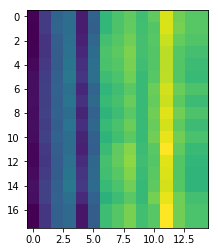

  sample 2:
    input     > 359000000000000
    predicted > 500077000000000000


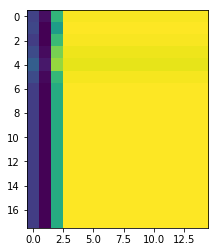

  sample 3:
    input     > 784888542525300
    predicted > 253253444442550044


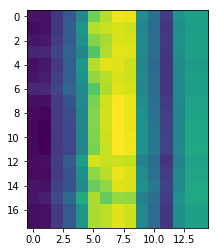


batch 500
  minibatch loss: 0.9773894548416138
  sample 1:
    input     > 485222435783825
    predicted > 222222228222222100


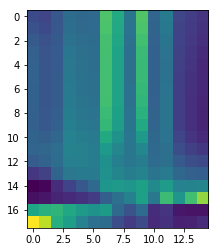

  sample 2:
    input     > 524942000000000
    predicted > 922224100000000000


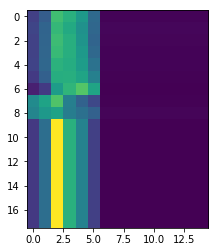

  sample 3:
    input     > 632272523493426
    predicted > 222222222222222100


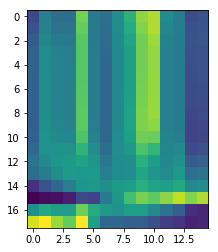


batch 1000
  minibatch loss: 0.8161724209785461
  sample 1:
    input     > 762593879640000
    predicted > 779999999641000000


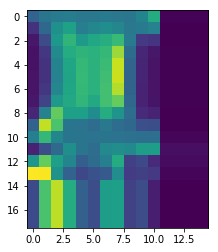

  sample 2:
    input     > 229000000000000
    predicted > 922100000000000000


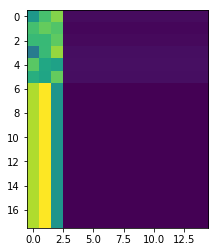

  sample 3:
    input     > 956238986300000
    predicted > 938888886610000000


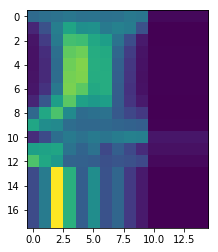


batch 1500
  minibatch loss: 0.40427055954933167
  sample 1:
    input     > 244227000000000
    predicted > 722442100000000000


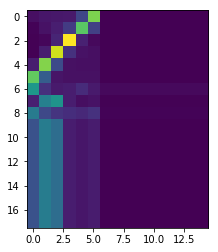

  sample 2:
    input     > 597429727000000
    predicted > 577729727100000000


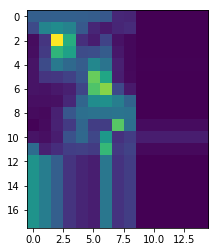

  sample 3:
    input     > 285456686679000
    predicted > 976666665552100000


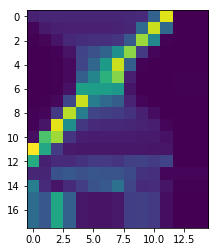


batch 2000
  minibatch loss: 0.03258783370256424
  sample 1:
    input     > 955700000000000
    predicted > 955710000000000000


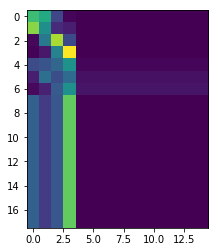

  sample 2:
    input     > 545575789300000
    predicted > 545575789310000000


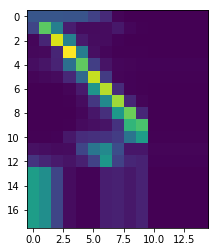

  sample 3:
    input     > 939477569400000
    predicted > 939477569410000000


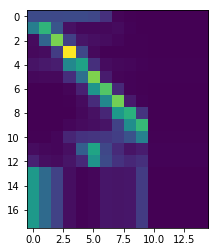


batch 2500
  minibatch loss: 0.007331058848649263
  sample 1:
    input     > 423499000000000
    predicted > 994324100000000000


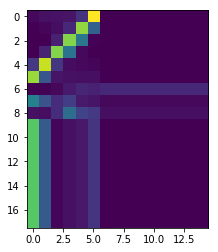

  sample 2:
    input     > 763442325275623
    predicted > 763442325275623100


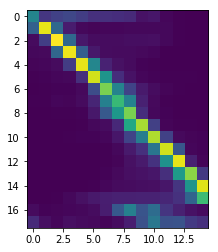

  sample 3:
    input     > 689637775000000
    predicted > 577736986100000000


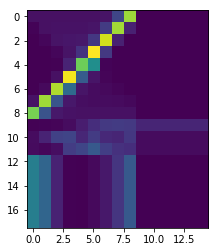


loss 0.0073 after 500200 examples (batch_size=200)


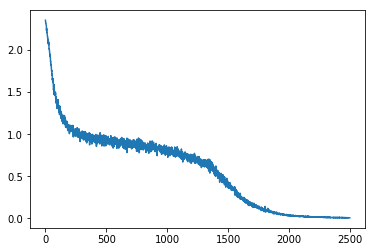

In [35]:
loss_track = []


max_batches = 2501
batches_in_epoch = 500

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_, atts = sess.run((decoder_prediction, bahdanau_attention_all_softmax), fd)
            for i, (inp, pred, att) in enumerate(zip(fd[encoder_inputs].T, predict_.T, atts)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(''.join([str(v) for v in inp])))
                print('    predicted > {}'.format(''.join([str(v) for v in pred])))
                plt.imshow(att)
                plt.show()
                if i >= 2:
                    break
            print()

except KeyboardInterrupt:
    print('training interrupted')


#%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], 
                                                             len(loss_track)*batch_size, batch_size))

* batch 0    -> Seq2Seq generate totally Random output 
* batch 500  -> Seq2Seq can correctly predict the sequence length
* batch 1000 -> Seq2Seq start to generate some correct tokens, but just few of them
* batch 1500 -> Seq2Seq start to learn Attention, but just for beginning and the end (bidirectional artefact)
* batch 2000 -> Seq2Seq use Attention for all token, especially in the middle (bidirectional artefact) to avoid the memory decay of the original Seq2Seq
* batch 2500 -> Perfect (loss ~ 0.) machine translation for this task